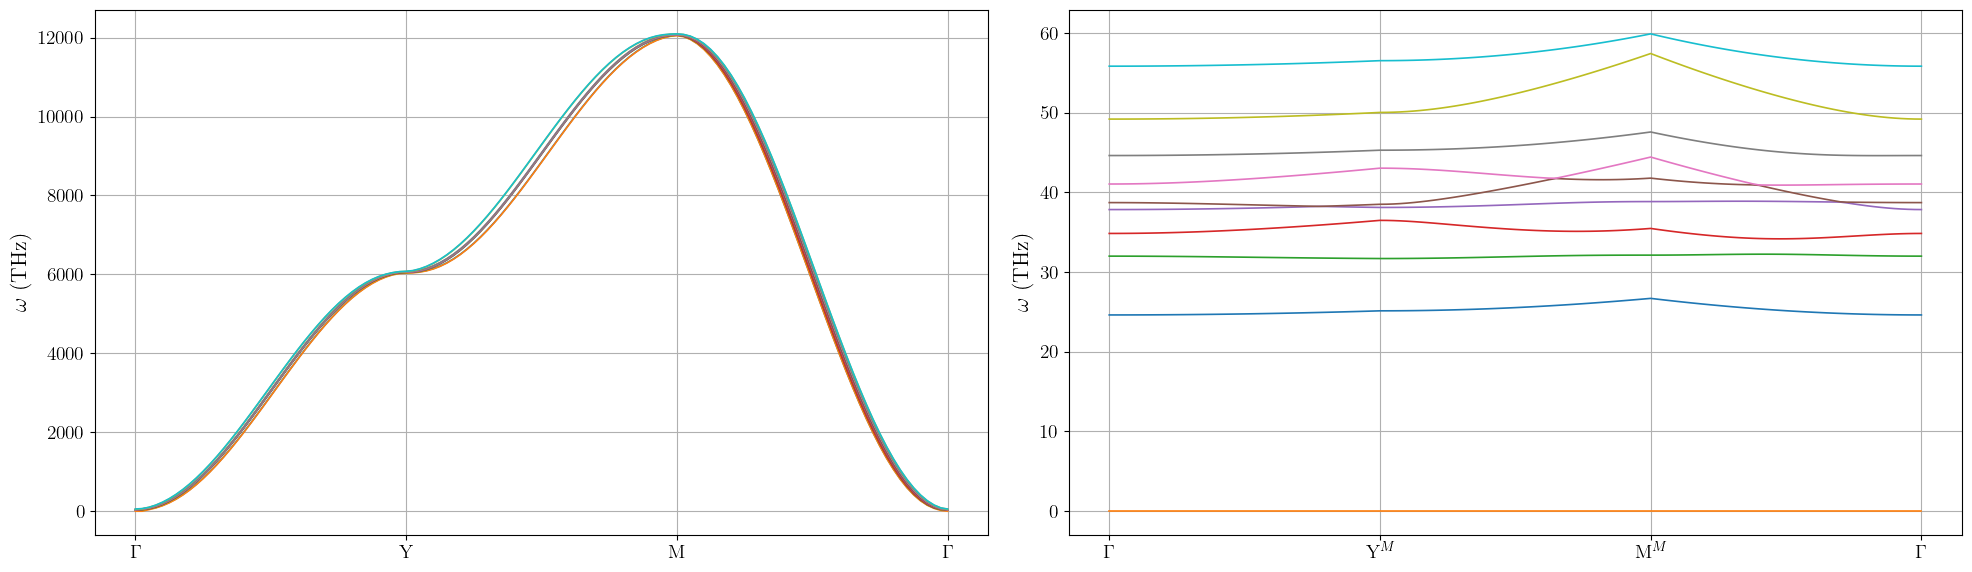

Threshold field = 0.6090 T


In [14]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 16,
    "font.size": 16,
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
})

# Parámetros físicos
S = 3/2
a = 3.54
b = 4.73
z = 4  # número de coordinación
J = 241.8* 4.15
JT = 241.8* 0.0155
#JT=0
Da = 241.8* 2*0.012 # D_X TUELING (I KNOW IT'S CHANGED, THEY HAVE DIFFERENT AXIS)
Dc = 241.8* 2*0.078 # D_Y TUELING (I KNOW IT'S CHANGED, THEY HAVE DIFFERENT AXIS)
B_T = 0.5 # External Field in Teslas (PARAMETER)
g=2 # g-factor for Cr^3+ (S=3/2 & L=0) is 2 exactly!
mu_B = 241.8* 0.05788  # Bohr magneton in GHz/T
B = g * mu_B * B_T  # Convert to GHz (THIS IS B FROM THE HAMILTONIAN)
  
theta_deg = 0.5
theta = np.radians(theta_deg)
# SPATIALLY-MODULATED J_T(R)
J_0 = JT
J_G = JT
# TYPE OF MBZ MAGNON
k_0=np.array([0, 0]) #TYPE OF MAGNON: 0 -> \Gamma, (PI/A, 0) -> Y, S -> (PI/A, PI/B)


#OUR MODEL: NN IN MOIRE RECIPROCAL SPACE -- FIRST ORDER IN MOIRE PLANE-WAVE EXPANSION
# Vectores recíprocos moiré
if theta_deg == 0:
    G_list = [np.array([0, 0])]
    J_G = 0
else:
    G_list = [np.array([0, 0]),
            np.array([4*np.pi*np.sin(theta/2)/b, 0]),
            -np.array([4*np.pi*np.sin(theta/2)/b, 0]),
            np.array([0, -4*np.pi*np.sin(theta/2)/a]),
            -np.array([0, -4*np.pi*np.sin(theta/2)/a])]



# SPATIALLY-MODULATED CANTING ANGLE \CHI(R)
threshold = (Da*np.cos(theta)*(2*S-1)/2 + 2*S*J_0)
if B < threshold:
    sin_chi_0 = B / threshold
    chi_0 = np.arcsin(sin_chi_0)
    cos_chi_0 = np.sqrt(1 - sin_chi_0**2)
    chi_G=-2*S*B*J_G/(cos_chi_0*threshold*threshold)
else:
    chi_0 = np.pi / 2
    sin_chi_0 = 1.0
    cos_chi_0 = 0.0
    chi_G=0

cos_2chi_0 = np.cos(2 * chi_0)
sin_2chi_0 = np.sin(2 * chi_0)

N_G = len(G_list)
dim = 4 * N_G

def gamma_k(k):
    return 2 * (np.cos(a * k[0]) + np.cos(b * k[1]))

# Coeficientes onsite
def h_d(k):
    return J_0*S*np.cos(2*chi_0) - J*S*(gamma_k(k) - z) + \
           Da*(S*np.cos(chi_0 + theta/2)**2 - (2*S - 1)*np.sin(chi_0 + theta/2)**2)/2 + \
           Dc*S/2 + B*np.sin(chi_0)

h_aa = -Da*S*np.cos(chi_0 + theta/2)**2/4 + Dc*S/4

# Coeficientes de acoplo directo entre capas
h_ab = J_0 * S * (1 + np.cos(2*chi_0)) / 2
h_abdag = J_0 * S * (1 - np.cos(2*chi_0)) / 2

# Construcción de H(k)
def build_H(k):
    H = np.zeros((dim, dim), dtype=np.complex128)
    for i, Gi in enumerate(G_list):
        ki = k +  - Gi
        idx_i = 4 * i

        # Términos diagonales
        H[idx_i, idx_i] = h_d(ki)
        H[idx_i+1, idx_i] = h_aa
        H[idx_i+1, idx_i+1] = h_d(ki)
        H[idx_i, idx_i+1] = h_aa

        H[idx_i+2, idx_i+2] = h_d(ki)
        H[idx_i+3, idx_i+2] = h_aa
        H[idx_i+3, idx_i+3] = h_d(ki)
        H[idx_i+2, idx_i+3] = h_aa

        # Acoplos directos
        H[idx_i, idx_i+2] = h_abdag
        H[idx_i, idx_i+3] = h_ab
        H[idx_i+1, idx_i+2] = h_ab
        H[idx_i+1, idx_i+3] = h_abdag

        H[idx_i+2, idx_i] = h_abdag
        H[idx_i+3, idx_i] = h_ab
        H[idx_i+2, idx_i+1] = h_ab
        H[idx_i+3, idx_i+1] = h_abdag

    # Interacción moiré entre G≠0
    for i in range(1, N_G):
        idx_i = 4 * i

        hM_d = J_G*S*np.cos(2*chi_0) + chi_G*(-2*S*J_0*np.sin(2*chi_0) - Da*(3*S-1)*np.sin(2*chi_0 + theta)/2 + B*np.cos(chi_0))
        hM_aa = Da*S*np.sin(2*chi_0 + theta)*chi_0 / 4
        hM_ab = J_G*S*(1 + np.cos(2*chi_0))/2 - S*J_0*np.sin(2*chi_0)*chi_G
        hM_abdag = J_G*S*(1 - np.cos(2*chi_0))/2 + S*J_0*np.sin(2*chi_0)*chi_G

        # Diagonal
        H[idx_i, 0] = hM_d
        H[idx_i+1, 0] = hM_aa
        H[idx_i+1, 1] = hM_d
        H[idx_i, 1] = hM_aa

        H[idx_i+2, 2] = hM_d
        H[idx_i+3, 2] = hM_aa
        H[idx_i+3, 3] = hM_d
        H[idx_i+2, 3] = hM_aa

        H[0, idx_i] = hM_d
        H[0, idx_i+1] = hM_aa
        H[1, idx_i+1] = hM_d
        H[1, idx_i] = hM_aa

        H[2, idx_i+2] = hM_d
        H[2, idx_i+3] = hM_aa
        H[3, idx_i+3] = hM_d
        H[3, idx_i+2] = hM_aa

        # Intercapa moiré
        H[idx_i, 2] = hM_abdag
        H[idx_i, 3] = hM_ab
        H[idx_i+1, 2] = hM_ab
        H[idx_i+1, 3] = hM_abdag

        H[idx_i+2, 0] = hM_abdag
        H[idx_i+3, 0] = hM_ab
        H[idx_i+2, 1] = hM_ab
        H[idx_i+3, 1] = hM_abdag

        H[2, idx_i] = hM_abdag
        H[3, idx_i] = hM_ab
        H[2, idx_i+1] = hM_ab
        H[3, idx_i+1] = hM_abdag

        H[0, idx_i+2] = hM_abdag
        H[0, idx_i+3] = hM_ab
        H[1, idx_i+2] = hM_ab
        H[1, idx_i+3] = hM_abdag

    return H

# Matriz BdG
S_bdg = np.diag([1 if i % 2 == 0 else -1 for i in range(dim)])

# Generate both BZ and MBZ paths
# Original BZ path (theta=0)
ky_max_bz = np.pi / a
kz_max_bz = np.pi / b
Gamma_bz = np.array([0, 0])
Y_bz = np.array([ky_max_bz, 0])
M_bz = np.array([ky_max_bz, kz_max_bz])
path_bz = [Gamma_bz, Y_bz, M_bz, Gamma_bz]

# Moiré BZ path (theta != 0)
ky_max_mbz = 2 * np.pi * np.sin(theta/2) / b
kz_max_mbz = 2 * np.pi * np.sin(theta/2) / a
Gamma_mbz = np.array([0, 0])
Y_mbz = np.array([ky_max_mbz, 0])
M_mbz = np.array([ky_max_mbz, kz_max_mbz])
path_mbz = [Gamma_mbz, Y_mbz, M_mbz, Gamma_mbz]

def interpolate_path(path, n_points=50):
    k_points = []
    for i in range(len(path)-1):
        start, end = path[i], path[i+1]
        for t in np.linspace(0, 1, n_points, endpoint=False):
            k_points.append((1-t)*start + t*end)
    k_points.append(path[-1])
    return np.array(k_points)

# Calculate eigenvalues for both paths
k_path_bz = interpolate_path(path_bz, n_points=40)
k_path_mbz = interpolate_path(path_mbz, n_points=40)

eigvals_bz = []
u_A_bz = []
u_B_bz = []

for k in k_path_bz:
    Hk = build_H(-k)
    Hk_bdg = S_bdg @ Hk
    eigvals, eigvecs = np.linalg.eig(Hk_bdg)

    # Normalize eigenvectors w.r.t. S
    for i in range(eigvecs.shape[1]):
        norm = np.real(eigvecs[:, i].conj().T @ S_bdg @ eigvecs[:, i])
        eigvecs[:, i] /= np.sqrt(np.abs(norm))

    # Sort eigenvalues and corresponding eigenvectors
    idx = eigvals.argsort()[::-1]
    eigvals = np.real(eigvals[idx])
    eigvecs = eigvecs[:, idx]

    # Select physical (positive norm) modes
    omega_k = eigvals[:2 * N_G]
    eigvecs_k = eigvecs[:, :2 * N_G]

    # Save frequencies
    eigvals_bz.append(omega_k)

    # Save u^{(A)}_n(k) and u^{(B)}_n(k)
    u_A_bz.append(eigvecs_k[0, :10])  # row 0: A-site creation operators
    u_B_bz.append(eigvecs_k[2, :10])  # row 2: B-site creation operators

# Convert to arrays
eigvals_bz = np.array(eigvals_bz)
u_A_bz = np.array(u_A_bz)
u_B_bz = np.array(u_B_bz)


    

eigvals_mbz = []
u_A_mbz = []
u_B_mbz = []

k_shift = np.array([0.0, 0.0])  # Adjust as needed

for k in k_path_mbz:
    Hk = build_H(k + k_shift)
    Hk_bdg = S_bdg @ Hk
    eigvals, eigvecs = np.linalg.eig(Hk_bdg)

    # Normalize eigenvectors w.r.t. S
    for i in range(eigvecs.shape[1]):
        norm = np.real(eigvecs[:, i].conj().T @ S_bdg @ eigvecs[:, i])
        eigvecs[:, i] /= np.sqrt(np.abs(norm))

    # Sort eigenvalues and vectors by descending real part
    idx = eigvals.argsort()[::-1]
    eigvals = np.real(eigvals[idx])
    eigvecs = eigvecs[:, idx]

    # Keep physical (positive norm) modes
    omega_k = eigvals[:2 * N_G]
    eigvecs_k = eigvecs[:, :2 * N_G]

    # Append frequencies
    eigvals_mbz.append(omega_k)

    # Append spin components (u^(A), u^(B))
    u_A_mbz.append(eigvecs_k[0, :10])  # A-site
    u_B_mbz.append(eigvecs_k[2, :10])  # B-site

    

# Convert to arrays
eigvals_mbz = np.array(eigvals_mbz)
u_A_mbz = np.array(u_A_mbz)
u_B_mbz = np.array(u_B_mbz)


# Plot both figures side by side
plt.figure(figsize=(20, 6))

# BZ plot
plt.subplot(1, 2, 1)
# First, manually plot the two swapped lowest bands
plt.plot(eigvals_bz[:, 2*N_G - 2], lw=1.2)  # Plot second-to-last band as lowest
plt.plot(eigvals_bz[:, 2*N_G - 1], lw=1.2)  # Plot last band as second-lowest

# Now plot the remaining bands in reverse order, skipping the two lowest ones
for band in reversed(range(2*N_G - 2)):
    plt.plot(eigvals_bz[:, band], lw=1.2)


plt.xticks([0, 40, 80, 120], [r'$\Gamma$', 'Y', 'M', r'$\Gamma$'])
plt.ylabel('$\omega$ (THz)')
plt.grid(True)

# MBZ plot
plt.subplot(1, 2, 2)
# First, manually plot the two swapped lowest bands
plt.plot(eigvals_mbz[:, 2*N_G - 2], lw=1.2)  # Plot second-to-last band as lowest
plt.plot(eigvals_mbz[:, 2*N_G - 1], lw=1.2)  # Plot last band as second-lowest

# Now plot the remaining bands in reverse order, skipping the two lowest ones
for band in reversed(range(2*N_G - 2)):
    plt.plot(eigvals_mbz[:, band], lw=1.2)
plt.xticks([0, 40, 80, 120], [r'$\Gamma$', r'Y$^M$', r'M$^M$', r'$\Gamma$'])
plt.ylabel('$\omega$ (THz)')
plt.grid(True)

plt.tight_layout()

plt.savefig("ROTATED_MAGNON_BAND.svg", format='svg', bbox_inches='tight')
plt.savefig("ROTATED_MAGNON_BAND.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Threshold field = {threshold / (g * mu_B):.4f} T")



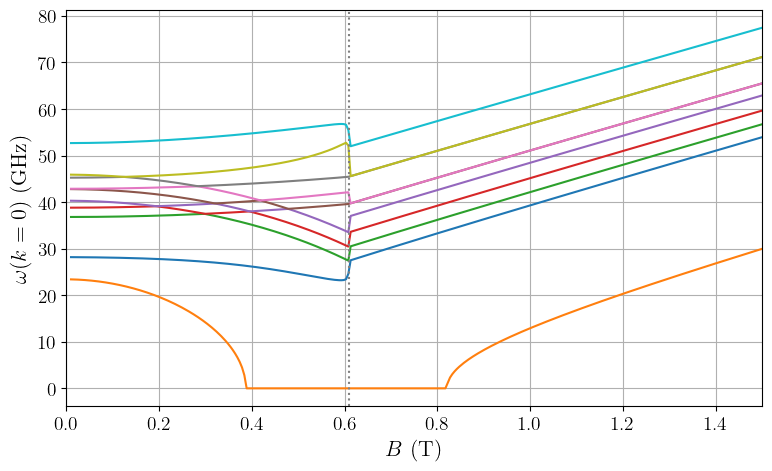

In [15]:
#PLOT \OMEGA(K=0) VS B - MOIRÉ MODULATED
threshold = (Da*np.cos(theta)*(2*S-1)/2 + 2*S*J_0)
def bdg_eigenvalues_k0(B_T_val):
    k_0 = np.array([0, 0])  # k=0
    B = g * mu_B  * B_T_val

    if B < threshold:
        sin_chi_0 = B / threshold
        chi_0 = np.arcsin(sin_chi_0)
        cos_chi_0 = np.sqrt(1 - sin_chi_0**2)
        chi_G=-2*S*B*J_G/(cos_chi_0*threshold*threshold)
    else:
        chi_0 = np.pi / 2
        sin_chi_0 = 1.0
        cos_chi_0 = 0.0
        chi_G=0

    N_G = len(G_list)
    dim = 4 * N_G

    def gamma_k(k):
        return 2 * (np.cos(a * k[0]) + np.cos(b * k[1]))

    # Coeficientes onsite
    def h_d(k):
        return J_0*S*np.cos(2*chi_0) - J*S*(gamma_k(k) - z) + \
            Da*(S*np.cos(chi_0 + theta/2)**2 - (2*S - 1)*np.sin(chi_0 + theta/2)**2)/2 + \
            Dc*S/2 + B*np.sin(chi_0)

    h_aa = -Da*S*np.cos(chi_0 + theta/2)**2/4 + Dc*S/4

    # Coeficientes de acoplo directo entre capas
    h_ab = J_0 * S * (1 + np.cos(2*chi_0)) / 2
    h_abdag = J_0 * S * (1 - np.cos(2*chi_0)) / 2

    # Construcción de H(k)
    def build_H_B(k):
        H = np.zeros((dim, dim))
        for i, Gi in enumerate(G_list):
            ki = k +  - Gi
            idx_i = 4 * i

            # Términos diagonales
            H[idx_i, idx_i] = h_d(ki)
            H[idx_i+1, idx_i] = h_aa
            H[idx_i+1, idx_i+1] = h_d(ki)
            H[idx_i, idx_i+1] = h_aa

            H[idx_i+2, idx_i+2] = h_d(ki)
            H[idx_i+3, idx_i+2] = h_aa
            H[idx_i+3, idx_i+3] = h_d(ki)
            H[idx_i+2, idx_i+3] = h_aa

            # Acoplos directos
            H[idx_i, idx_i+2] = h_abdag
            H[idx_i, idx_i+3] = h_ab
            H[idx_i+1, idx_i+2] = h_ab
            H[idx_i+1, idx_i+3] = h_abdag

            H[idx_i+2, idx_i] = h_abdag
            H[idx_i+3, idx_i] = h_ab
            H[idx_i+2, idx_i+1] = h_ab
            H[idx_i+3, idx_i+1] = h_abdag

        # Interacción moiré entre G≠0
        for i in range(1, N_G):
            idx_i = 4 * i

            hM_d = J_G*S*np.cos(2*chi_0) + chi_G*(-2*S*J_0*np.sin(2*chi_0) - Da*(3*S-1)*np.sin(2*chi_0 + theta)/2 + B*np.cos(chi_0))
            hM_aa = Da*S*np.sin(2*chi_0 + theta)*chi_0 / 4
            hM_ab = J_G*S*(1 + np.cos(2*chi_0))/2 - S*J_0*np.sin(2*chi_0)*chi_G
            hM_abdag = J_G*S*(1 - np.cos(2*chi_0))/2 + S*J_0*np.sin(2*chi_0)*chi_G

            # Diagonal
            H[idx_i, 0] = hM_d
            H[idx_i+1, 0] = hM_aa
            H[idx_i+1, 1] = hM_d
            H[idx_i, 1] = hM_aa

            H[idx_i+2, 2] = hM_d
            H[idx_i+3, 2] = hM_aa
            H[idx_i+3, 3] = hM_d
            H[idx_i+2, 3] = hM_aa

            H[0, idx_i] = hM_d
            H[0, idx_i+1] = hM_aa
            H[1, idx_i+1] = hM_d
            H[1, idx_i] = hM_aa

            H[2, idx_i+2] = hM_d
            H[2, idx_i+3] = hM_aa
            H[3, idx_i+3] = hM_d
            H[3, idx_i+2] = hM_aa

            # Intercapa moiré
            H[idx_i, 2] = hM_abdag
            H[idx_i, 3] = hM_ab
            H[idx_i+1, 2] = hM_ab
            H[idx_i+1, 3] = hM_abdag

            H[idx_i+2, 0] = hM_abdag
            H[idx_i+3, 0] = hM_ab
            H[idx_i+2, 1] = hM_ab
            H[idx_i+3, 1] = hM_abdag

            H[2, idx_i] = hM_abdag
            H[3, idx_i] = hM_ab
            H[2, idx_i+1] = hM_ab
            H[3, idx_i+1] = hM_abdag

            H[0, idx_i+2] = hM_abdag
            H[0, idx_i+3] = hM_ab
            H[1, idx_i+2] = hM_ab
            H[1, idx_i+3] = hM_abdag

        return H

    H=build_H_B(k_0)
    # Matriz BdG
    S_bdg = np.diag([1 if i % 2 == 0 else -1 for i in range(dim)])
    eigvals = np.linalg.eigvals(S_bdg @ H)
    eigvals = np.real(eigvals)
    eigvals = np.sort(eigvals)[::-1]
    return eigvals[:2*N_G]

# Sweep field B_T and compute bands at k = 0
B_T_vals = np.linspace(0.01, 1.5, 300)
bands_vs_B = np.array([bdg_eigenvalues_k0(BT) for BT in B_T_vals])

# Plot
plt.figure(figsize=(8, 5))
# First plot the swapped lowest two bands
plt.plot(B_T_vals, bands_vs_B[:, -2])
plt.plot(B_T_vals, bands_vs_B[:, -1])

# Now plot the rest in reversed order, skipping the last two
for i in reversed(range(bands_vs_B.shape[1] - 2)):
    plt.plot(B_T_vals, bands_vs_B[:, i])


plt.axvline(threshold/(g *mu_B), color='gray', linestyle=':')
plt.xlabel(r'$B$ (T)')
plt.ylabel(r'$\omega(k=0)$ (GHz)')
#plt.ylim(0,0.08)
plt.xlim(0,1.5)
plt.grid(True)
plt.tight_layout()
plt.savefig("OMEGA_B_ROTATED.svg", format='svg', bbox_inches='tight')
plt.show()

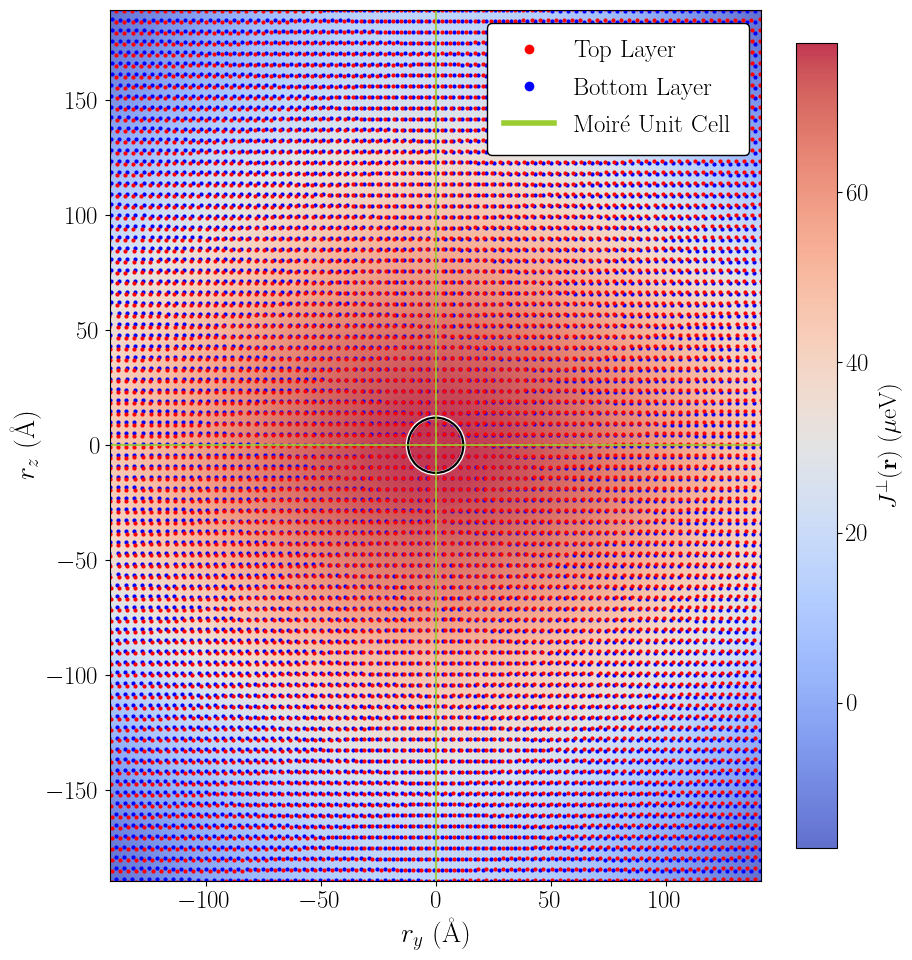

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Circle

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 20,
    "font.size": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
})

# Parameters
a = 3.54  # lattice const along y-axis (Angstrom)
b = 4.73  # lattice const along z-axis (Angstrom)
theta_deg = 0.5  # twist angle degrees
theta = np.deg2rad(theta_deg)
n = 40  # lattice size

# Function to generate rotated rectangular lattice
def generate_rect_lattice(a, b, n, theta, offset=(0, 0)):
    y = np.arange(-n, n + 1) * a + offset[0]
    z = np.arange(-n, n + 1) * b + offset[1]
    Y, Z = np.meshgrid(y, z)
    coords = np.vstack([Y.ravel(), Z.ravel()])
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    rotated_coords = R @ coords
    return rotated_coords.T

# Generate layers
bottom_layer = generate_rect_lattice(a, b, n, theta=-theta / 2)
top_layer = generate_rect_lattice(a, b, n, theta=theta / 2)

# Moiré lattice vectors
denom = 2 * np.sin(theta / 2)
aM1 = a / denom * np.array([0, 1])  # z-direction
aM2 = b / denom * np.array([1, 0])  # y-direction

# Scalar field grid
grid_res = 500
lim_y = n * a
lim_z = n * b
y_grid = np.linspace(-lim_y, lim_y, grid_res)
z_grid = np.linspace(-lim_z, lim_z, grid_res)
Y, Z = np.meshgrid(y_grid, z_grid)

# Constants for scalar field
J_0 = 15.5
J_G = J_0

# Scalar field T(r)
T = J_0 + (2 * J_G) * (np.cos((4 * np.pi * np.sin(theta / 2)) * Z / a) +
                       np.cos((4 * np.pi * np.sin(theta / 2)) * Y / b))

# Start plotting
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')

# Scalar field background
im = ax.pcolormesh(y_grid, z_grid, T, shading='auto', cmap='coolwarm', alpha=0.8)

# Lattice layers (dots)
ax.scatter(bottom_layer[:, 0], bottom_layer[:, 1], color='blue', s=4, alpha=1, label='Bottom Layer')
ax.scatter(top_layer[:, 0], top_layer[:, 1], color='red', s=4, alpha=1, label='Top Layer')

# Draw moiré unit cells tiling entire visible area
max_i = int(2 * lim_y / np.linalg.norm(aM2)) + 1
max_j = int(2 * lim_z / np.linalg.norm(aM1)) + 1

for i in range(-max_i, max_i + 1):
    for j in range(-max_j, max_j + 1):
        cell_origin = i * aM2 + j * aM1
        square = np.array([
            cell_origin,
            cell_origin + aM2,
            cell_origin + aM2 + aM1,
            cell_origin + aM1,
            cell_origin
        ])
        ax.plot(square[:, 0], square[:, 1], color='yellowgreen', linewidth=1.5, alpha=0.6)
        center = cell_origin + 0.5 * (aM1 + aM2)
        ax.scatter(*center, color='yellowgreen', s=30, alpha=0.7)

# Add AA and AB stacking circles with white outlines
ab_center = (aM1 + aM2) / 2
white_ab_circle = Circle(ab_center, radius=12.2, edgecolor='white', facecolor='none', linewidth=2.8)
main_ab_circle = Circle(ab_center, radius=12, edgecolor='black', facecolor='none', linewidth=1.5)
ax.add_patch(white_ab_circle)
ax.add_patch(main_ab_circle)

aa_center = np.array([0, 0])
white_aa_circle = Circle(aa_center, radius=12.2, edgecolor='white', facecolor='none', linewidth=2.8)
main_aa_circle = Circle(aa_center, radius=12, edgecolor='black', facecolor='none', linewidth=1.6)
ax.add_patch(white_aa_circle)
ax.add_patch(main_aa_circle)

# Axes labels and limits
L = 150  # plotting range in Angstroms
ax.set_xlim(-lim_y, lim_y)
ax.set_ylim(-lim_z, lim_z)
ax.set_xlabel(r"$r_y\ (\mathrm{\AA})$")
ax.set_ylabel(r"$r_z\ (\mathrm{\AA})$")

# Legend with custom handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Top Layer',
           markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Bottom Layer',
           markerfacecolor='blue', markersize=8),
    Line2D([0], [0], color='yellowgreen', lw=4, label='Moiré Unit Cell'),
]
ax.legend(handles=legend_elements, loc='upper right',
          frameon=True, framealpha=1, edgecolor='black',
          handlelength=2, handletextpad=0.8, borderpad=0.7, labelspacing=0.6)

# Colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r"$J^\perp(\mathbf{r})$ ($\mu$eV)", fontsize=18)

plt.tight_layout()


plt.savefig("J_PERP.svg", format='svg', bbox_inches='tight')
plt.savefig("J_PERP.png", dpi=300, bbox_inches='tight')

plt.show()



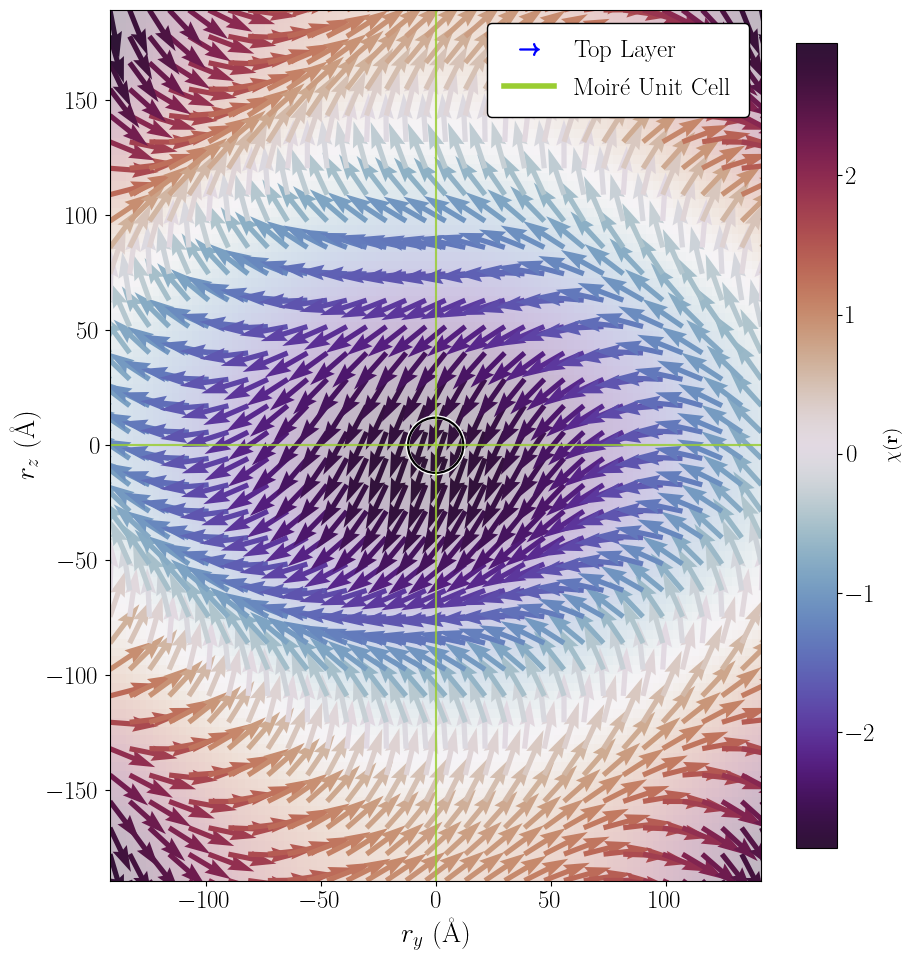

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Circle

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 20,
    "font.size": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
})

# Parámetros físicos (replicar los que usas en el primer bloque)
S = 3/2
a = 3.54
b = 4.73
theta_deg = 0.5
theta = np.radians(theta_deg)

# Variables necesarias para el cálculo (asegúrate de definirlas si no vienen de antes)
J_0 = 0.2418 * 0.0155  # ejemplo: interlayer coupling
J_G = J_0 
Da = 0.2418 * 2 * 0.012  # anisotropía
B_T = 0.5
g = 2
mu_B = 0.2418 * 0.05788
B = g * mu_B * B_T

# Tamaño y malla para la textura
n = 40
lim_y = n * a
lim_z = n * b
grid_res = 100
y = np.linspace(-lim_y, lim_y, grid_res)
z = np.linspace(-lim_z, lim_z, grid_res)
Y, Z = np.meshgrid(y, z)

ry = Y
rz = Z

# Cálculo ángulo de canting espacialmente modulada chi(r)
threshold = (Da * np.cos(theta) * (2 * S - 1) / 2 + 2 * S * J_0)
if B < threshold:
    sin_chi_0 = B / threshold
    chi_0 = np.arcsin(sin_chi_0)
    cos_chi_0 = np.sqrt(1 - sin_chi_0**2)
    chi_G = -2 * S * B * J_G / (cos_chi_0 * threshold ** 2)
    chi = chi_0 + 2 * chi_G * (np.cos((4 * np.pi * np.sin(theta / 2)) * rz / a) +
                              np.cos((4 * np.pi * np.sin(theta / 2)) * ry / b))
else:
    chi_0 = np.pi / 2
    chi = chi_0 * np.ones_like(Y)
    chi_G = 0

# Calculamos las componentes de spin para quiver
S_y = S * np.sin(chi)
S_z = S * np.cos(chi)

# Subsample grid for quiver — exactly step=3 for your perfect density
step = 3
Y_sub = Y[::step, ::step]
Z_sub = Z[::step, ::step]
S_y_sub = S_y[::step, ::step]
S_z_sub = S_z[::step, ::step]
chi_sub = chi[::step, ::step]


# Normalización para el colormap de chi
norm = Normalize(vmin=np.min(chi), vmax=np.max(chi))
cmap = plt.get_cmap('twilight_shifted')

# Then plot quiver as usual
q = ax.quiver(Y_sub, Z_sub, S_y_sub, S_z_sub,
              chi_sub,  # scalar field for coloring
              cmap='twilight_shifted', norm=norm,
              scale=20, width=0.008, headlength=5)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')

# Fondo scalar field chi
im = ax.pcolormesh(y, z, chi, shading='auto', cmap=cmap, alpha=0.3)

# Quiver con spins coloreado por chi
q = ax.quiver(Y_sub, Z_sub, S_y_sub, S_z_sub, chi_sub,
              cmap=cmap, norm=norm, scale=20, width=0.008, headlength=5)

# Vectores de la red moiré
denom = 2 * np.sin(theta / 2)
aM1 = a / denom * np.array([0, 1])
aM2 = b / denom * np.array([1, 0])

# Dibuja las celdas unitarias moiré con color yellowgreen (igual que en tu primer gráfico)
max_i = int(2 * lim_y / np.linalg.norm(aM2)) + 1
max_j = int(2 * lim_z / np.linalg.norm(aM1)) + 1

for i in range(-max_i, max_i + 1):
    for j in range(-max_j, max_j + 1):
        cell_origin = i * aM2 + j * aM1
        square = np.array([
            cell_origin,
            cell_origin + aM2,
            cell_origin + aM2 + aM1,
            cell_origin + aM1,
            cell_origin
        ])
        ax.plot(square[:, 0], square[:, 1], color='yellowgreen', linewidth=1.5, alpha=0.6)
        center = cell_origin + 0.5 * (aM1 + aM2)
        ax.scatter(*center, color='yellowgreen', s=30, alpha=0.7)

# Círculos AA y AB con borde blanco
ab_center = (aM1 + aM2) / 2
white_ab_circle = Circle(ab_center, radius=12.2, edgecolor='white', facecolor='none', linewidth=2.8)
main_ab_circle = Circle(ab_center, radius=12, edgecolor='black', facecolor='none', linewidth=1.5)
ax.add_patch(white_ab_circle)
ax.add_patch(main_ab_circle)

aa_center = np.array([0, 0])
white_aa_circle = Circle(aa_center, radius=12.2, edgecolor='white', facecolor='none', linewidth=2.8)
main_aa_circle = Circle(aa_center, radius=12, edgecolor='black', facecolor='none', linewidth=1.6)
ax.add_patch(white_aa_circle)
ax.add_patch(main_aa_circle)

# Límites y etiquetas
ax.set_xlim(-lim_y, lim_y)
ax.set_ylim(-lim_z, lim_z)

ax.set_xlabel(r"$r_y\ (\mathrm{\AA})$")
ax.set_ylabel(r"$r_z\ (\mathrm{\AA})$")



# Legend with custom handles
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, marker=r'$\rightarrow$', markersize=14, label='Top Layer', linestyle='None'),
    Line2D([0], [0], color='yellowgreen', lw=4, label='Moiré Unit Cell'),
]
ax.legend(handles=legend_elements, loc='upper right',
          frameon=True, framealpha=1, edgecolor='black',
          handlelength=2, handletextpad=0.8, borderpad=0.7, labelspacing=0.6)

# Barra de color para chi
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r"$\chi(\mathbf{r})$", fontsize=14)

plt.tight_layout()

plt.savefig("CHI(R).svg", format='svg', bbox_inches='tight')
plt.savefig("CHI(R).png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
Delta=12 # Spin gap in THz
g_A = 0.01
g_B = 0.01
N= 1 #UNIT THIS IS THE NUMBER OF CR ATOMS!!
#r_y=b/(4*np.sin(theta/2))
#r_z=a/(4*np.sin(theta/2))
#r_y=b/(2*np.sin(theta/2))
#r_z=a/(2*np.sin(theta/2))
r_y=0
r_z=0

Nk=200
eta = 0.1  # ancho de línea en THz
ky_vals_bz = np.linspace(-ky_max_bz, ky_max_bz, Nk)
kz_vals_bz = np.linspace(-kz_max_bz, kz_max_bz, Nk)
KY_bz, KZ_bz = np.meshgrid(ky_vals_bz, kz_vals_bz, indexing='ij')


delta_ky = (2 * ky_max_bz) / (Nk - 1)
delta_kz = (2 * kz_max_bz) / (Nk - 1)
dk2 = delta_ky * delta_kz  # Área diferencial en k-espacio

Gamma_total = 0
Gamma_map = np.zeros((Nk, Nk))  # para almacenar Gamma(k) en cada punto

eigvals_bz_Nk = []
eigvecs_bz_Nk = [] 

u_A_bz_Nk = []
u_B_bz_Nk = []

for i in range(Nk):
    for j in range(Nk):
        ky = KY_bz[i, j]
        kz = KZ_bz[i, j]
        kvec = np.array([ky, kz])

        HNk = build_H(kvec)
        HNk_bdg = S_bdg @ HNk
        eigvals_Nk, eigvecs_Nk = np.linalg.eig(HNk_bdg)

        # Normalize eigenvectors w.r.t. S
        for t in range(eigvecs_Nk.shape[1]):
            norm = np.real(eigvecs_Nk[:, t].conj().T @ S_bdg @ eigvecs_Nk[:, t])
            eigvecs_Nk[:, t] /= np.sqrt(np.abs(norm))

        # Sort eigenvalues and vectors by descending real part
        idx = eigvals_Nk.argsort()[::-1]
        eigvals_Nk = np.real(eigvals_Nk[idx])
        eigvecs_Nk = eigvecs_Nk[:, idx]

        # Keep physical (positive norm) modes
        omega_Nk = eigvals_Nk[:2 * N_G]
        eigvecs_Nk = eigvecs_Nk[:, :2 * N_G]

        u_A_bz_Nk = eigvecs_Nk[0, :10]
        u_B_bz_Nk = eigvecs_Nk[2, :10]

        # Append frequencies
        eigvals_bz_Nk.append(omega_k)

        # f_r, prefactor, alpha_k, beta_k igual que en H_SM
        f_r = np.cos(4 * np.pi * np.sin(theta / 2) * r_z / a) + \
            np.cos(4 * np.pi * np.sin(theta / 2) * r_y / b)
        prefactor = np.sqrt(S / (2 * N)) * np.exp(1j * (kvec[0]*r_y+kvec[1]*r_z))

        alpha_Nk = g_A * prefactor * (1 - np.cos(chi_0) + np.sin(chi_0) * 2 * chi_G * f_r)
        beta_Nk  = g_B * prefactor * (1 + np.cos(chi_0) - np.sin(chi_0) * 2 * chi_G * f_r)

        lambdas_Nk = alpha_Nk * u_A_bz_Nk + beta_Nk * u_B_bz_Nk

        # Cálculo de tasa de decaimiento
        Gamma_k = 0
        for n in range(len(omega_Nk)):
            num = np.abs(lambdas_Nk[n])**2 * eta
            den = (Delta - omega_Nk[n])**2 + eta**2
            Gamma_k += 2 * num / den
        
        Gamma_k_GHz = Gamma_k * 1000  # Convert THz to GHz

        Gamma_total += Gamma_k_GHz * dk2
        Gamma_map[i, j] = Gamma_k_GHz
        
print(f"Gamma total: {Gamma_total} GHz")
plt.figure(figsize=(6, 5))
plt.pcolormesh(ky_vals_bz, kz_vals_bz, Gamma_map.T, shading='auto', cmap='bwr', vmin=0, vmax=6)
plt.colorbar(label=r'$\Gamma(\mathbf{k};\,\mathbf{r}=0)$ (GHz$\cdot$Å$^{2}$)')
plt.xlabel(r'$k_y$ (Å$^{-1}$)')
plt.ylabel(r'$k_z$ (Å$^{-1}$)')

plt.xlim(-ky_max_bz, ky_max_bz)
plt.ylim(-kz_max_bz, kz_max_bz)

# Define x ticks at 0.2 increments
xticks = np.arange(-0.8, 0.8 + 0.01, 0.4)  # from -0.8 to 0.8 by 0.2

# Set x ticks explicitly
plt.gca().set_xticks(xticks)

plt.savefig("BZ_DELTA_6.svg", format='svg', bbox_inches='tight')
plt.show()


In [ ]:
from joblib import Parallel, delayed

Delta_0=6 # Spin gap in THz
g_A = 0.01
g_B = 0.01
N= 1 #UNIT THIS IS THE NUMBER OF CR ATOMS!!
#r_y=b/(4*np.sin(theta/2))
#r_z=a/(4*np.sin(theta/2))
#r_y=b/(2*np.sin(theta/2))
#r_z=a/(2*np.sin(theta/2))
r_y_0=0
r_z_0=0

Nk=100
N_r=100
eta_0 = 0.1  # ancho de línea en THz
ky_vals_bz = np.linspace(-ky_max_bz, ky_max_bz, Nk)
kz_vals_bz = np.linspace(-kz_max_bz, kz_max_bz, Nk)
KY_bz, KZ_bz = np.meshgrid(ky_vals_bz, kz_vals_bz, indexing='ij')


delta_ky = (2 * ky_max_bz) / (Nk - 1)
delta_kz = (2 * kz_max_bz) / (Nk - 1)
dk2 = delta_ky * delta_kz  # Área diferencial en k-espacio


def compute_Gamma_total_r(r_y, r_z, Delta, eta):
    Gamma_total_r = 0.0
    Gamma_map_r = np.zeros((Nk, Nk), dtype=np.float64)

    for i_r in range(Nk):
        for j_r in range(Nk):
            ky_r = KY_bz[i_r, j_r]
            kz_r = KZ_bz[i_r, j_r]
            kvec_r = np.array([ky_r, kz_r])

            HNk_r = build_H(kvec_r)
            HNk_bdg_r = S_bdg @ HNk_r
            eigvals_r, eigvecs_r = np.linalg.eig(HNk_bdg_r)

            # Normalize eigenvectors w.r.t. S
            for t_r in range(eigvecs_r.shape[1]):
                norm_r = np.real(eigvecs_r[:, t_r].conj().T @ S_bdg @ eigvecs_r[:, t_r])
                eigvecs_r[:, t_r] /= np.sqrt(np.abs(norm_r))

            # Sort eigenvalues and vectors by descending real part
            idx_r = eigvals_r.argsort()[::-1]
            eigvals_r = np.real(eigvals_r[idx_r])
            eigvecs_r = eigvecs_r[:, idx_r]

            # Keep physical (positive norm) modes
            omega_r = eigvals_r[:2 * N_G]
            eigvecs_r = eigvecs_r[:, :2 * N_G]

            u_A_r = eigvecs_r[0, :10]
            u_B_r = eigvecs_r[2, :10]

            v_A_r = eigvecs_r[1, :10]   # from gamma^\dagger_{n,-k}
            v_B_r = eigvecs_r[3, :10]

            # f_r, prefactor, alpha_k, beta_k as in H_SM
            f_r = np.cos(4 * np.pi * np.sin(theta / 2) * r_z / a) + \
                  np.cos(4 * np.pi * np.sin(theta / 2) * r_y / b)
            prefactor_r = np.sqrt(S / (2 * N)) * np.exp(1j * (kvec_r[0] * r_y + kvec_r[1] * r_z))

            alpha_r = (g_A*u_A_r+g_B*v_B_r)* prefactor_r * (1 - np.cos(chi_0) + np.sin(chi_0) * 2 * chi_G * f_r)
            beta_r  = (g_A*v_A_r+g_B*u_B_r) * prefactor_r * (1 + np.cos(chi_0) - np.sin(chi_0) * 2 * chi_G * f_r)

            lambdas_r = alpha_r + beta_r                                         

            Gamma_k_r = 0.0
            for n_r in range(len(omega_r)):
                num_r = np.abs(lambdas_r[n_r])**2 * eta
                den_r = (Delta - omega_r[n_r])**2 + eta**2
                Gamma_k_r += 2 * num_r / den_r

            Gamma_total_r += Gamma_k_r * dk2
            Gamma_map_r[i_r, j_r] = Gamma_k_r

    return Gamma_total_r, Gamma_map_r

# Step 1: Worker function
def gamma_worker(r_y, r_z):
    gamma, _ = compute_Gamma_total_r(r_y, r_z, Delta_0, eta_0)
    return gamma

# Step 2: Grid definition (as before)
denom = 4 * np.sin(theta / 2)
r_y_vals = np.linspace(-b / denom, b / denom, N_r)
r_z_vals = np.linspace(-a / denom, a / denom, N_r)
RY, RZ = np.meshgrid(r_y_vals, r_z_vals, indexing='ij')

# Step 3: Flatten input grid to list of coordinate pairs
coords = [(r_y, r_z) for r_y in r_y_vals for r_z in r_z_vals]

# Step 4: Run in parallel!
results = Parallel(n_jobs=-1, backend="loky")(delayed(gamma_worker)(r_y, r_z) for r_y, r_z in coords)

# Step 5: Reshape results to original grid shape
Gamma_total_map = np.array(results).reshape(N_r, N_r)

# Step 6: Plot (same as before)
plt.figure(figsize=(7, 6))
plt.pcolormesh(r_y_vals, r_z_vals, Gamma_total_map.T, shading='auto', cmap='inferno')
plt.colorbar(label=r'$\Gamma_{\mathrm{total}}$ (THz)')
plt.xlabel(r'$r_y$')
plt.ylabel(r'$r_z$')
plt.title(r'$\Gamma_{\mathrm{total}}(r_y, r_z)$')
plt.show()

In [ ]:

# Definir rango de Delta (en THz)
Delta_vals = np.linspace(-1, 13, 2)  # Ajusta el rango y número de puntos según convenga

Gamma_total_vs_Delta = []

for Delta in Delta_vals:
    Gamma_total, _ = compute_Gamma_total_r(r_y, r_z, Delta, eta_0)
    Gamma_total_vs_Delta.append(Gamma_total)

Gamma_total_vs_Delta = np.array(Gamma_total_vs_Delta)

plt.figure(figsize=(7,5))
plt.plot(Delta_vals, Gamma_total_vs_Delta, marker='o')
plt.xlabel(r'$\Delta$ (THz)')
plt.ylabel(r'$\Gamma_{\mathrm{total}}$ (THz)')
plt.title(r'$\Gamma_{\mathrm{total}}$ vs $\Delta$')
plt.grid(True)
plt.show()